### Reading csvs

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk

In [5]:
df1 = pd.read_csv('./dataset/DOSSPRE 1.0Original.csv')
df2 = pd.read_csv('./dataset/software_requirements_extended.csv')
# Creating final csv with combined requirements
final_df = pd.DataFrame(pd.concat([df1['Requirement'], df2['Requirement']], ignore_index=True))
final_df.head()

,Requirement
0,'The system shall detect SQL Injection and XSS...
1,'The system shall analyze the detected vulnera...
2,'The system shall identify acceptable low fals...
3,'The system shall inspect SSL certificate '
4,'The system shall generate a report of the det...


In [6]:
# Use for the first time only 

# final_df.to_csv("./dataset/final_combined.csv")

## General EDA

> #### Analyzing text statistics
> Text statistics visualizations are simple but very insightful techniques. 

> They include:
> - word frequency analysis,
> - sentence length analysis,
> - average word length analysis,
> - etc.

<Axes: >

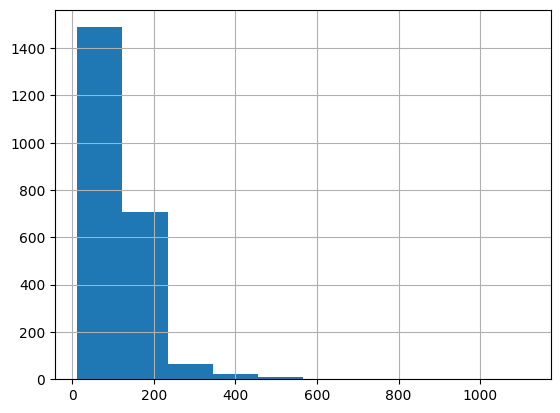

In [10]:
# The histogram shows that requirements length range from 10 to 500 characters and generally, mostly it lies between 10 to 250 characters.
final_df['Requirement'].str.len().hist()

<Axes: >

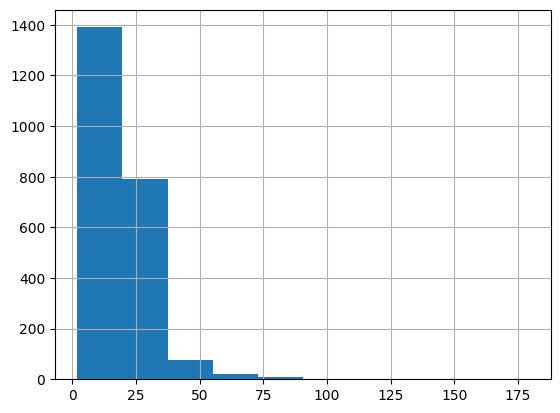

In [13]:
# No of words appering in each requirement
final_df['Requirement'].str.split().map(lambda x: len(x)).hist()

> ### Removing Stopwords

In [46]:

from nltk.corpus import stopwords
from nltk import Counter

In [20]:
nltk.download('stopwords')
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\priya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<BarContainer object of 10 artists>

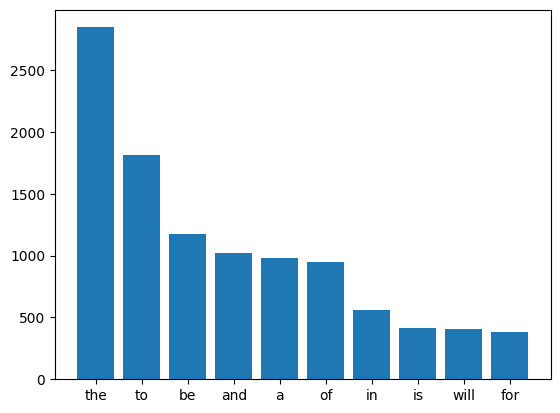

In [43]:
# Creating corpus

corpus=[]
new = final_df['Requirement'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict

word_dict=defaultdict(int)
for word in corpus:
    if word in stop:
        word_dict[word]+=1

top=sorted(word_dict.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

<Axes: >

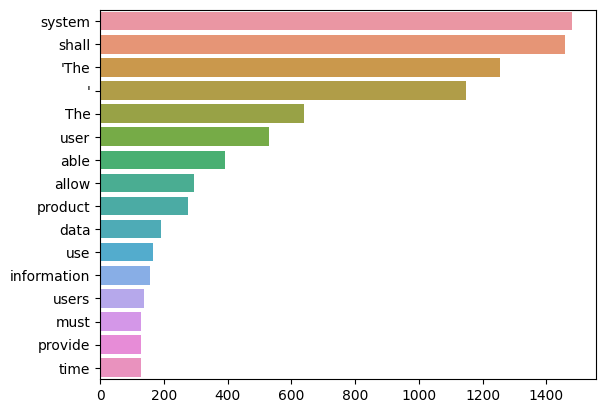

In [47]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)